## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

### Define the target function 

leminscate of Bernoulli is defined as : ((x² + y²)² - 4*(x² - y²)) 

ellipse is defined as : ((x - 0.5)² + 4*(y - 1/3)² - 2)

f(x,y) is the the union of Lemniscate and ellipse :

f(x,y) = ((x² + y²)² - 4*(x² - y²)) * ((x - 0.5)² + 4*(y - 1/3)² - 2)

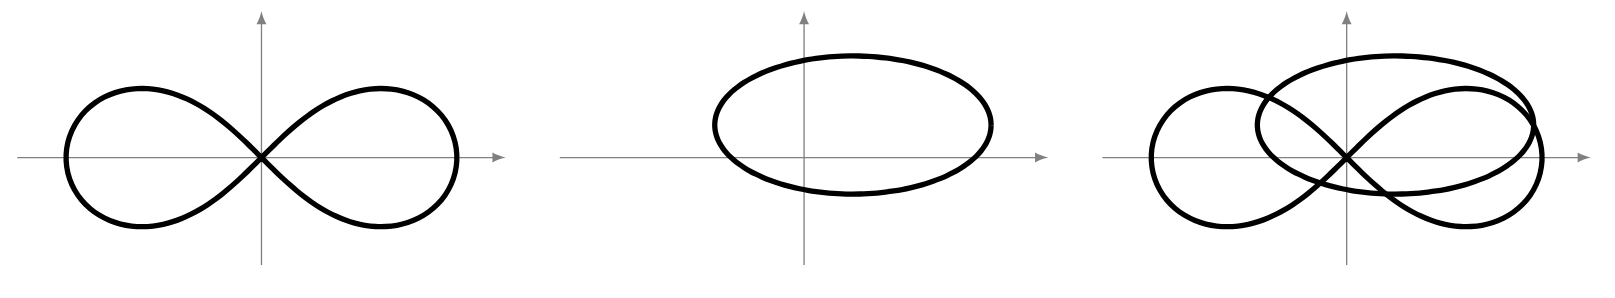

In [2]:
def f(x, y):
    return ((x**2 + y**2)**2 - 4*(x**2 - y**2)) * ((x - 0.5)**2 + 4*(y - 1/3)**2 - 2)

### Create the color label
Red zone : f(x,y) <= 0
Blue zone : f(x,y) > 0

In [3]:
def label_zone(x, y):
    return (f(x, y) <= 0).astype(np.float32)

### Create a grid of points in [-2, 2] x [-1, 1]

In [ ]:
n = 200 # for 200x200 grid
x_vals = np.linspace(-2, 2, n)
y_vals = np.linspace(-1, 1, n)
xx, yy = np.meshgrid(x_vals, y_vals)
X = np.vstack([xx.ravel(), yy.ravel()]).T

In [ ]:
y_true = label_zone(X[:, 0], X[:, 1]).reshape(-1, 1)

# Convert to PyTorch tensors and send to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y_true).float().to(device)

#### Neural network parameters

In [ ]:
p = 20   # neurons per hidden layer -> 3*p = 60 neurons total
batch_size = 256
epochs = 500
lr = 0.1 # for SGD

In [ ]:
# Define a 4-layer network: 2->p->p->p->1 with ReLU activations
class Net(nn.Module):
    def __init__(self, p):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, p),
            nn.ReLU(),
            nn.Linear(p, p), # p -> p 
            nn.ReLU(),
            nn.Linear(p, p),
            nn.ReLU(),
            nn.Linear(p, 1),
            nn.Sigmoid() # binary classification
        )

    def forward(self, x):
        return self.layers(x)

### Exemple for p = 3

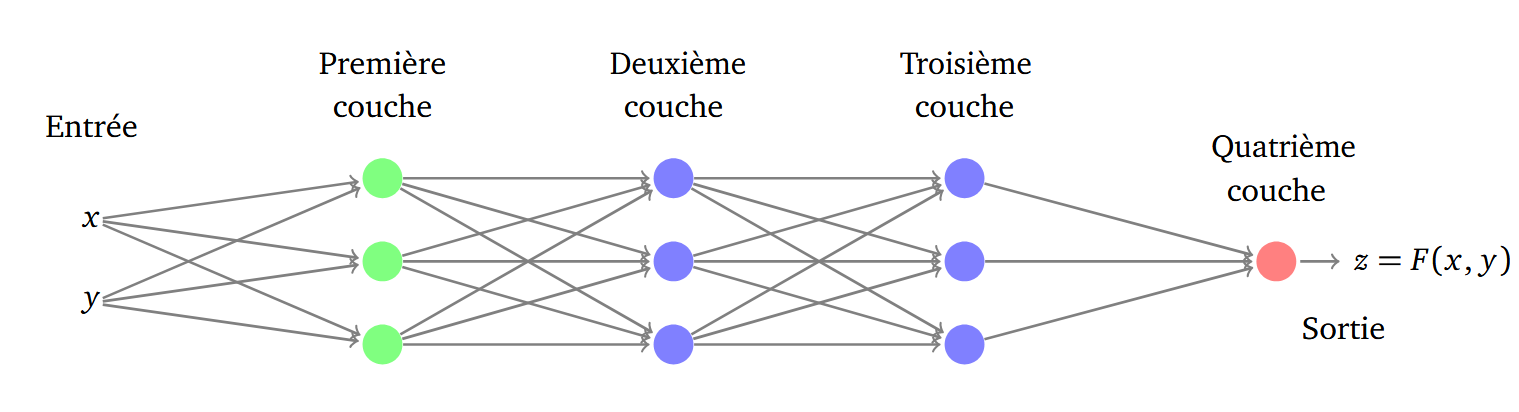

In [ ]:
model = Net(p).to(device)
criterion = nn.BCELoss() # Binary Cross Entropy Loss for binary classification
optimizer = optim.SGD(model.parameters(), lr=lr)

In [9]:
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Training Loop

In [ ]:
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_x) # forward
        loss = criterion(outputs, batch_y) # loss
        loss.backward() # backward
        optimizer.step() # weighs update
        running_loss += loss.item() * batch_x.size(0)
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Loss: {running_loss/len(dataset):.4f}")

Epoch 1/500 - Loss: 0.6741
Epoch 50/500 - Loss: 0.1070
Epoch 100/500 - Loss: 0.0701
Epoch 150/500 - Loss: 0.0569
Epoch 200/500 - Loss: 0.0511
Epoch 250/500 - Loss: 0.0507
Epoch 300/500 - Loss: 0.0444
Epoch 350/500 - Loss: 0.0418
Epoch 400/500 - Loss: 0.0404
Epoch 450/500 - Loss: 0.0364
Epoch 500/500 - Loss: 0.0348


### Evaluate 

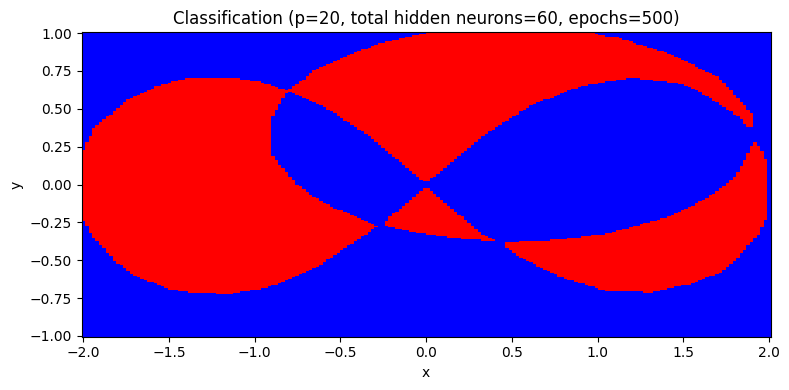

In [11]:
model.eval()
with torch.no_grad():
    preds = model(X_tensor).cpu().numpy().reshape(n, n)

plt.figure(figsize=(8, 4)) # Red where preds >= 0.5, Blue where preds < 0.5
plt.pcolormesh(xx, yy, preds >= 0.5, shading='auto', cmap='bwr')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Classification (p={p}, total hidden neurons={3*p}, epochs={epochs})')
plt.tight_layout()
plt.savefig('classification_result.png')
